# Path Classification via Neural $1$-forms

In this notebook we give a small example of $1$-form neural networks applied to simple path classification task.

In [9]:
import numpy as np
import matplotlib as mpl
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors

import neural_kforms as nkf


## 1-form Simplicial Representation Learning: Vector Fields

As a first example, we will consider vector fields over $\mathbb{R}^2$. $1$-forms, which are in bijection with and dual to vector fields, can be written in the form:
$\begin{equation} \omega = \alpha_x(x,y) dx + \alpha_y(x,y) dy \end{equation}$ where both $\alpha_x$ and $\alpha_y$ are functions from $\mathbb{R}^2$ to $\mathbb{R}$. By the identification
$ \begin{equation} \mathsf{Hom}(\mathbb{R}^2, \mathbb{R}) \oplus  \mathsf{Hom}(\mathbb{R}^2, \mathbb{R}) \cong \mathsf{Hom}(\mathbb{R}^2, \mathbb{R}^2)  \end{equation}$ we can represent a $1$-form as a single function from $\mathbb{R}^2 \to \mathbb{R}^2$. To learn such a function, we define a simple MLP below which goes from $\mathbb{R}^2 \to \mathbb{R}^2$.

In [10]:
import torch

import torch.nn as nn
 
c = 6 # number of features/columns in cochain data matrix

vf = nn.Sequential(
    nn.Linear(2, 2*c)
)

To drive home the fact that the above MLP actually defines a vector field, we can plot it. The 'tangent vector' at each point $(x,y) \in \mathbb{R}^2$ is the vector given by
$\begin{equation}  (\alpha_x(x,y),\alpha_y(x,y)) \end{equation}$ which corresponds to the MLP above via
$\begin{equation} \alpha_x(x,y) = \pi_x \circ \text{vf.forward}(x,y) \end{equation}$ and $\begin{equation} f_y(x,y) = \pi_y \circ \text{vf.forward}(x,y). \end{equation}$

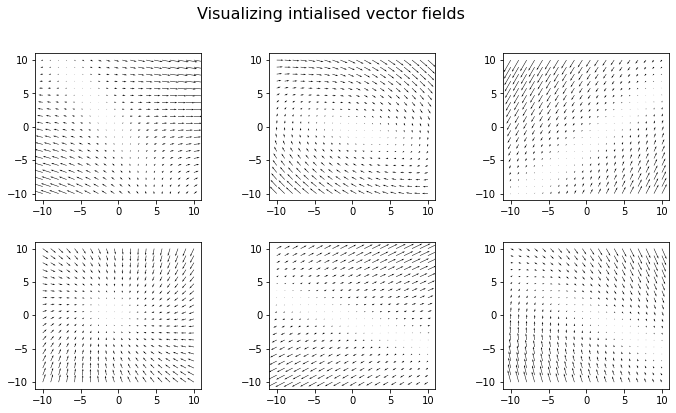

In [22]:
# make a figure with 6 subplots arranged in 2 rows and 3 columns
for i in range(c):
    ax = plt.subplot(2, 3, i+1)
    nkf.plot_component_vf(vf, ax, comp = i, x_range=10, y_range=10)


# add a title   
plt.suptitle('Visualizing intialised vector fields', fontsize=16)


# adjust the spacing between subplots
plt.tight_layout()

# make plt bigger
plt.gcf().set_size_inches(10, 6)

# show the figure
plt.show()


### Synthetic Path Generation

We first need a few functions for doing efficient path integration in this setting.

In [34]:
def generate_diagonal_paths(num_paths=100,eps = 0.02, num_pts = 50):
    
    Paths = []
    for i in range(num_paths): 
        x = np.sort(np.random.uniform(low=-1, high=1, size=num_pts))
        noise_x= np.random.uniform(low= -eps, high = eps,  size = num_pts)
        noise_y= np.random.uniform(low= -eps, high = eps,  size = num_pts)

        x_trans = np.random.randint(-2,2)
        y_trans = np.random.randint(-2,2)

        r = np.random.uniform(0.2, 2.5)

        x_values = list(r*x+noise_x+x_trans)
        y_values = list(r*np.sin(x+noise_y)+ y_trans)

        path = np.stack((x_values,y_values))
    
        Paths.append(path.T)
        
    return Paths


def generate_antidiagonal_paths(num_paths=100,eps = 0.01, num_pts = 50):
    
    Paths = []
    for i in range(num_paths): 
        x = np.sort(np.random.uniform(low=-1, high=1, size=num_pts))

        noise_x= np.random.uniform(low= -eps, high = eps,  size = num_pts)
        noise_y= np.random.uniform(low= -eps, high = eps,  size = num_pts)

        x_trans = np.random.randint(-2,2)
        y_trans = np.random.randint(-2,2)

        r = np.random.uniform(0.2, 2.5)

        x_values = list(r*x+noise_x + x_trans)
        y_values = list(-r*np.sin(x+noise_y)+y_trans)
        path = np.stack((x_values,y_values))
    
        Paths.append(path.T)
        
    return Paths
        



def generate_circular_paths(num_paths=100,eps = 0.02, num_pts = 50):
    
    Paths = []
    for i in range(num_paths): 
        endpoint = np.random.randint(0,num_pts)

        k = np.random.randint(1,4)
        phase = np.random.uniform(0,2*np.pi)
        
        sample_angles = list(np.sort(np.random.uniform(0,2*np.pi/k, num_pts)+phase))

        #angles= sample_angles[endpoint:]+ sample_angles[:endpoint]
        angles = np.array(sample_angles)
        
        noise_x= np.random.uniform(low= -eps, high = eps,  size = num_pts)
        noise_y= np.random.uniform(low= -eps, high = eps,  size = num_pts)

        x_trans = np.random.randint(-5,5)
        y_trans = np.random.randint(-5,5)

        r = np.random.uniform(0.2, 2.5)

        x_values = r*np.cos(angles)+noise_x
        y_values = r*np.sin(angles)+noise_y

        path = np.stack((x_values,y_values))
    
        Paths.append(path.T)

    return Paths

In [35]:
# generate data
noise = 0.05
pts = 50

p0 = generate_diagonal_paths(num_paths=100,eps = noise, num_pts = pts)
p1 = generate_antidiagonal_paths(num_paths=100,eps = noise, num_pts = pts)
p2 = generate_circular_paths(num_paths=100,eps = noise, num_pts = pts)

# join together p0, p1, p2
paths = p0+p1+p2

In [36]:
# generate labels
labels = np.concatenate((np.zeros(100),np.ones(100),2*np.ones(100)))

# perform a one hot encoding of the labels and transform to torch
labels = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64))

In [37]:
# turn the above into a function, which takes in a path and ax and plots the path on the ax
def plot_path(path,ax, head_width=0.1, head_length=0.1, alpha = 0.5, color = 'blue', linewidth = 0.5):

    ax.plot(path[:,0],path[:,1], alpha = alpha, color = color, linewidth = linewidth)

    ax.arrow(path[-2,0],path[-2,1],(path[-1,0]-path[-2,0])/3,(path[-1,1]-path[-2,1])/3,head_width = head_width, head_length=head_length, alpha = alpha, color = color)
    
    return ax

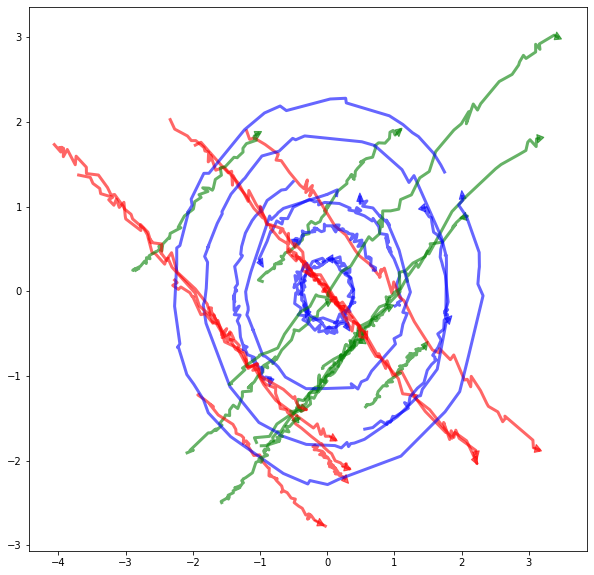

In [38]:
fig, ax = plt.subplots(1,1,figsize = (10,10))

for i in range(10):


    plot_path(paths[0+i], ax, color = 'green', alpha = 0.6, linewidth = 3)

    plot_path(paths[100+i], ax, color = 'red', alpha = 0.6, linewidth = 3)

    plot_path(paths[200+i], ax, color = 'blue', alpha = 0.6, linewidth = 3)


# save figure
plt.savefig('figures/synthetic-paths/training_paths.png')

plt.show()

In [39]:
# a function for calculating the length of a path
def path_length(path):
    """
    Calculates the length of a path
    """
    length = 0
    for i in range(len(path)-1):
        length += np.linalg.norm(path[i+1]-path[i])
    return length

### Neural $k$-form Classification Model

First up, we initialise the vector field as a simple MLP with ReLU activations.

In [45]:
c = 3 # number of features/columns in cochain data matrix

# intialise 3 neural vector field/1-forms with 2 hidden layers
vf = nn.Sequential(
    nn.Linear(2, 50),
    nn.ReLU(),
    nn.Linear(50, 30),
    nn.ReLU(),
    nn.Linear(30, 2*c)
)

We can plot the corresponding vector fields below. Note that these are a result of the standard random weight initialisations. 

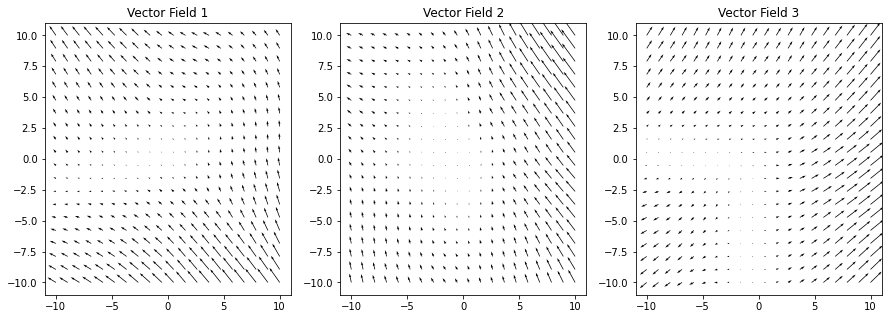

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    ax = axs[i]
    plot_component_vf(vf, ax, comp = i, x_range=10, y_range=10)
    ax.set_title('Vector Field {}'.format(i+1))

plt.show()

# save the figure
fig.savefig('./figures/synthetic-paths/initial_vf.png')


By looking at the summed rows of the corresponding cochain data matrix, we get a mapping from each path to $\mathbb{R}^3$, where 3 is the number of feature vector fields and the coordinates corespond to integration along each vector field. As we can see, the initialised vector fields do not generate representations that separate the paths into the three classes.

/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_93310/1173586545.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(torch.nn.functional.softmax(X))


Accuracy: 0.07


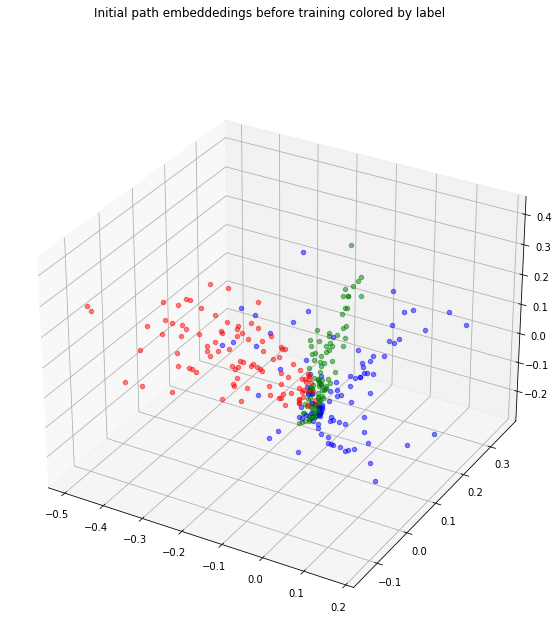

In [47]:
# make a 3d scatter plot of vf evaluated on the set of paths, colored by labels
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

correct = 0

for i in range(len(paths)):
        
        p = paths[i]
        l = labels[i]

        # convert the path into an embedded edge chain
        p = nkf.path_to_chain(p)

        # calculate the integration matrix of the embedded chain against the neural vector fields
        X = nkf.integration_matrix(vf, p, d = 5)
        
        # column sum read-out layer
        X = torch.sum(X, dim = 0)

        # prediction
        lb = torch.argmax(l)
        pred = torch.argmax(torch.nn.functional.softmax(X))

        # calculate accuracy
        if pred == lb:
            correct +=1
        
        # add to plot
        if lb == 0:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), X[2].detach().numpy(), color = 'green', alpha = 0.5)
        elif lb == 1:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), X[2].detach().numpy(), color = 'red', alpha = 0.5)
        elif lb == 2:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), X[2].detach().numpy(), color = 'blue', alpha = 0.5)


print('Accuracy: {}'.format(correct/len(paths)))


# add a title to the figure
fig.suptitle('Initial path embeddedings before training colored by label')

# save the figure
fig.savefig('./figures/synthetic-paths/initial_embeddings.png')

plt.show()

### Training and Gradient Descent

Now we begin the training phase. We use stand SGD with a learning rate of 0.01 and a momentum of 0.9. We train for 50 epoches and employ a Cross-Entropy loss.

In [48]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(vf.parameters(), lr=1e-2)

criterion = nn.CrossEntropyLoss()


/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_93310/3332479734.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sm = torch.nn.functional.softmax(X)


Epoch =  0 Loss =  tensor(1.0297)
Epoch =  1 Loss =  tensor(0.8538)
Epoch =  2 Loss =  tensor(0.7670)
Epoch =  3 Loss =  tensor(0.7308)
Epoch =  4 Loss =  tensor(0.7083)
Epoch =  5 Loss =  tensor(0.6900)
Epoch =  6 Loss =  tensor(0.6745)
Epoch =  7 Loss =  tensor(0.6620)
Epoch =  8 Loss =  tensor(0.6521)
Epoch =  9 Loss =  tensor(0.6440)
Epoch =  10 Loss =  tensor(0.6371)
Epoch =  11 Loss =  tensor(0.6318)
Epoch =  12 Loss =  tensor(0.6267)
Epoch =  13 Loss =  tensor(0.6225)
Epoch =  14 Loss =  tensor(0.6187)
Epoch =  15 Loss =  tensor(0.6155)
Epoch =  16 Loss =  tensor(0.6124)
Epoch =  17 Loss =  tensor(0.6099)
Epoch =  18 Loss =  tensor(0.6074)
Epoch =  19 Loss =  tensor(0.6054)
Epoch =  20 Loss =  tensor(0.6034)
Epoch =  21 Loss =  tensor(0.6016)
Epoch =  22 Loss =  tensor(0.6000)
Epoch =  23 Loss =  tensor(0.5986)
Epoch =  24 Loss =  tensor(0.5972)
Epoch =  25 Loss =  tensor(0.5959)
Epoch =  26 Loss =  tensor(0.5947)
Epoch =  27 Loss =  tensor(0.5936)
Epoch =  28 Loss =  tensor(0.5

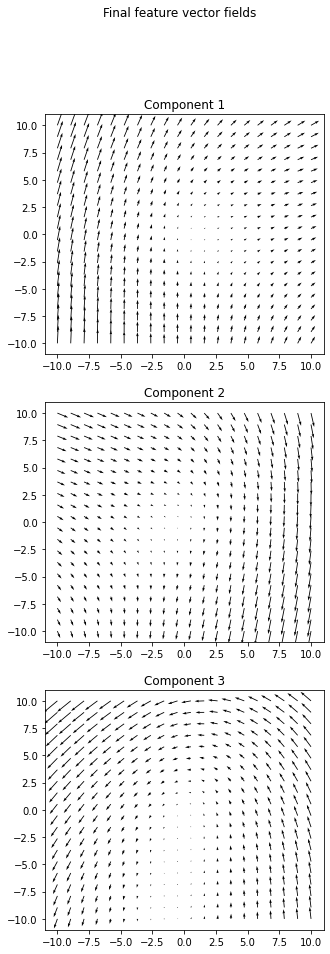

In [49]:
epochs = 50

batch_size = 300

losses = torch.zeros((batch_size,epochs))

for j in range(epochs):

    # make a random choice of size batch_size
    idx = np.random.choice(len(paths), size=batch_size, replace=False)

    batch_paths = [paths[i] for i in idx]
    batch_labels = labels[idx]

        
    for i in range(batch_size):

        p = batch_paths[i]
        l = batch_labels[i]

        # convert the path into an embedded edge chain
        p = nkf.path_to_chain(p)
        
        # calculate the integration matrix of the embedded chain against the neural vector fields
        X = nkf.integration_matrix(vf, p, d = 5)

        # column sum read-out layer
        X = torch.sum(X, dim = 0)

        # prediction
        sm = torch.nn.functional.softmax(X)

        # calculate loss
        loss = criterion(sm,l.float())
        losses[i,j] = loss.detach()

        
        # backprop
        loss.backward()

        # for some reason it works better doing the backprop/gradient step after each path

        optimizer.step()

        optimizer.zero_grad()

    # clear print statement from previous iteration
    # clear_output(wait=True)
    
    print("Epoch = ", j, "Loss = ", torch.sum(losses[:,j])/batch_size)


fig, axs = plt.subplots(3, 1, figsize=(5, 15))

for i in range(3):
    ax = axs[i]
    plot_component_vf(vf, ax, comp = i, x_range=10, y_range=10)
    ax.set_title('Component {}'.format(i+1))

# add a title to the figure
fig.suptitle('Final feature vector fields')

plt.show()

As we see below, the loss behaves very nicely with respect to the epochs. 

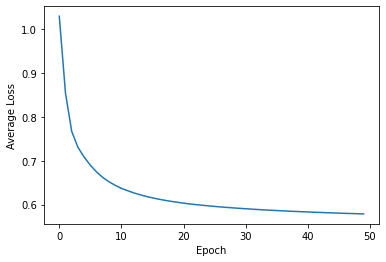

In [50]:
# plot the loss
L = torch.sum(losses,axis=0)/batch_size
plt.plot(L)

# add x and y labels
plt.xlabel('Epoch')
plt.ylabel('Average Loss')

# save the figure
plt.savefig('./figures/synthetic-paths/training-loss.png')

plt.show()

/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_90895/3658918362.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(torch.nn.functional.softmax(X))


Accuracy of the network on the 300 training paths: 98 %


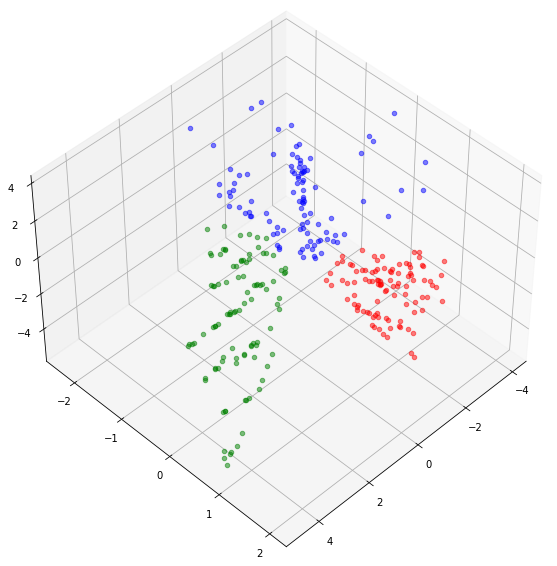

In [18]:
# make a 3d scatter plot of vf evaluated on the set of paths, colored by labels
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

# evaluate the accuracy of the classifier on the training data
correct = 0
total = 0

for i in range(len(paths)):
        
        p = paths[i]
        l = labels[i]
        
        p = path_to_chain(p)
        X = gen_CDM2(vf, p)
        
        X = torch.sum(X, dim = 0)/path_length(p)

        lb = torch.argmax(l)

        pred = torch.argmax(torch.nn.functional.softmax(X))

        if pred == torch.argmax(l):
                correct += 1
        total += 1
        
        
        if lb == 0:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), X[2].detach().numpy(), color = 'green', alpha = 0.5)
        elif lb == 1:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), X[2].detach().numpy(), color = 'red', alpha = 0.5)
        elif lb == 2:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), X[2].detach().numpy(), color = 'blue', alpha = 0.5)


print('Accuracy of the network on the 300 training paths: %d %%' % (100 * correct / total))

# rotate the figure

ax.view_init(45, 45)


# save the figure
fig.savefig('./figures/synthetic-paths/final-embeddings.png')

plt.show()



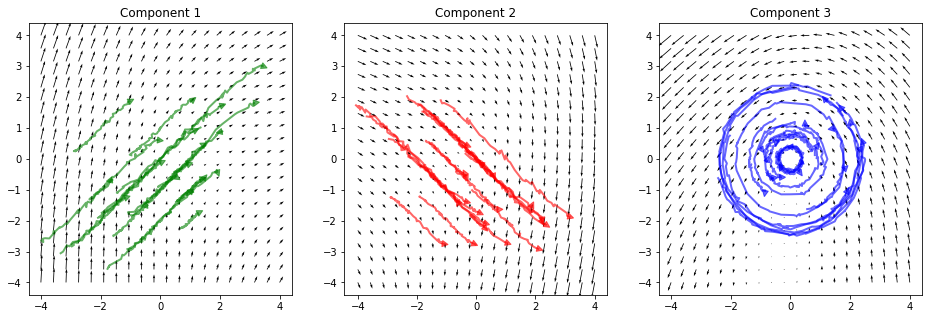

In [51]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

# plot the three component vector fields
for i in range(3):
    ax = axs[i]
    plot_component_vf(vf, ax, comp = i, x_range=4, y_range=4)
    ax.set_title('Component {}'.format(i+1))

# add example paths from each class
for i in range(20):

    plot_path(paths[0+i], axs[0], color = 'green', head_width=0.2, head_length = 0.2, alpha = 0.6, linewidth = 2)

    plot_path(paths[100+i], axs[1], color = 'red', head_width=0.2, head_length = 0.2, alpha = 0.6, linewidth = 2)

    plot_path(paths[200+i], axs[2], color = 'blue', head_width=0.2, head_length = 0.2, alpha = 0.6, linewidth = 2)

# save the figure
fig.savefig('./figures/synthetic-paths/final-vf.png')

plt.show()

## 0-forms: Scalar Fields

Many authors have considered whether comparable results can be performed by networks that take only the point cloud of embedded vertices into account. To test whether the $1$-simplices are in fact necessary, we will take a $0$-form cochain representation network with as many parameters as the above as a comparison.

To clarify, a $0$-form cochain neural network consists of learning $c$-features (for $c \in \mathbb{N}$) where each feature is a function from $\mathbb{R}^2 \to \mathbb{R}$. This can modelled as a simple MLP i.e. a function from $\mathbb{R}^2 \to \mathbb{R}^c$ with a finite number of parameters. 

### Initialisation

We initiaise the function below, and note that this has slightly more paramters than our previous model.

In [53]:
c = 3 # number of features/columns in cochain data matrix

# intialise 3 neural scalar functions with 2 hidden layers
scalar = nn.Sequential(
    nn.Linear(2, 50),
    nn.ReLU(),
    nn.Linear(50, 32),
    nn.ReLU(),
    nn.Linear(32, c)
)

# print the total number of parameters in the model
print("Total Number of Parameters: ", sum(p.numel() for p in scalar.parameters()))

Total Number of Parameters:  1881


Like the previous example, we can plot individual $0$-form component features as scalar fields over $\mathbb{R}^2$, where $\mathbb{R}^2$ is the ambient embedding spaces of the nodes. This gives a helpful aid in interpreting the results of the network.

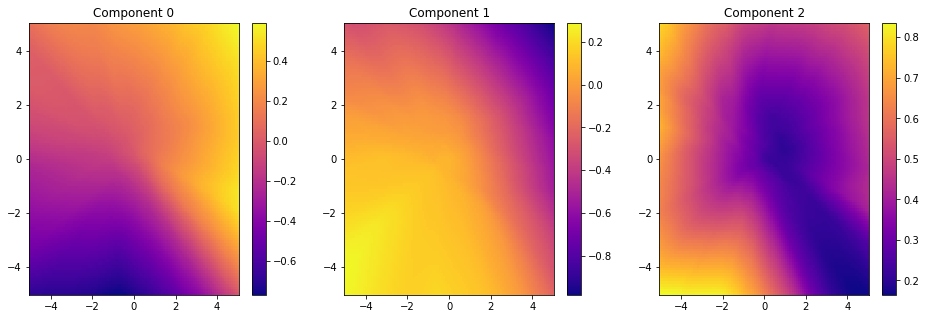

In [54]:
# a function to plot a heatmap of the scalar field
def plot_scalar_field_comp(scalar, ax, comp = 0, x_range = 5, y_range = 5, n = 100):
    x = np.linspace(-x_range, x_range, n)
    y = np.linspace(-y_range, y_range, n)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            Z[i,j] = scalar(torch.tensor([X[i,j],Y[i,j]]).float())[comp]
    ax.pcolormesh(X, Y, Z, cmap = 'viridis')

    # add a colorbar
    fig.colorbar(ax.pcolormesh(X, Y, Z, cmap = 'plasma'), ax=ax)

    # add a title labelling the component
    ax.set_title('Component {}'.format(comp))


fig, axs = plt.subplots(1, 3, figsize=(16, 5))

# plot the three component vector fields
for i in range(3):
    ax = axs[i]
    plot_scalar_field_comp(scalar, ax, comp = i, x_range=5, y_range=5)

# add a title to the figure
# fig.suptitle('Initial feature scalar fields')

# save the figure
fig.savefig('./figures/synthetic-paths/initial-scalar-fields.png')

plt.show()

Again, as in the previous example, specifiying 3 features means that we embed set of points corresponding to a path into $\mathbb{R}^3$. To demonstrate, we show the embedding of the three paths in the dataset below at the initialisation stage.

/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_93310/153285778.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(torch.nn.functional.softmax(X))


Accuracy of the network on the 300 training paths: ", 33 %


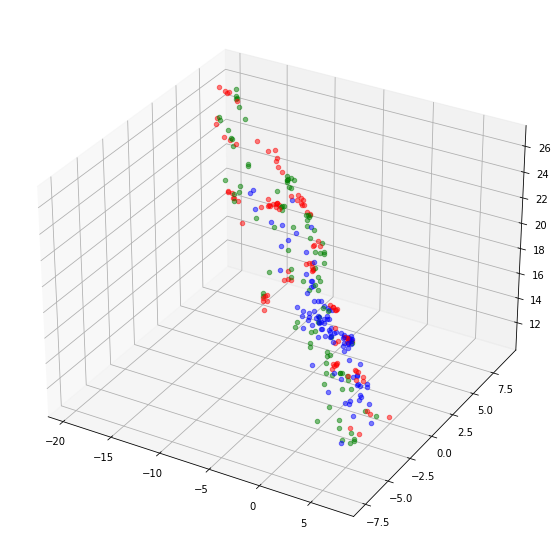

In [55]:
# make a 3d scatter plot of vf evaluated on the set of paths, colored by labels
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

# evaluate the accuracy of the classifier on the training data
correct = 0
total = 0

for i in range(len(paths)):
        
        p = paths[i]
        l = labels[i]
        
        out = scalar(torch.tensor(p).float())
        X = torch.sum(out, dim = 0)

        lb = torch.argmax(l)

        pred = torch.argmax(torch.nn.functional.softmax(X))

        if pred == torch.argmax(l):
                correct += 1
        total += 1
        
        
        if lb == 0:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), X[2].detach().numpy(), color = 'green', alpha = 0.5)
        elif lb == 1:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), X[2].detach().numpy(), color = 'red', alpha = 0.5)
        elif lb == 2:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), X[2].detach().numpy(), color = 'blue', alpha = 0.5)


# add a title to the figure
# ax.set_title('Initial feature scalar field embedding')

# print accuracy
print('Accuracy of the network on the 300 training paths: ", %d %%' % (100 * correct / total))

### Training

To make the results comparable, we use the same loss, SGD and epoch parameters as before

In [56]:
import torch.optim as optim

# create your optimizer
scalar_optimizer = optim.SGD(scalar.parameters(), lr=1e-5)

scalar_criterion = nn.CrossEntropyLoss()

In [57]:
epochs = 50

batch_size = 300

losses = torch.zeros((batch_size,epochs))

for j in range(epochs):

    # make a random choice of size batch_size
    idx = np.random.choice(len(paths), size=batch_size, replace=False)

    #idx = np.arange(batch_size)
    batch_paths = [paths[i] for i in idx]
    batch_labels = labels[idx]

        
    for i in range(batch_size):

        p = batch_paths[i]
        l = batch_labels[i]

        out = scalar(torch.tensor(p).float())
        out = torch.sum(out, dim = 0)
        
        sm = torch.nn.functional.softmax(out)


        loss = scalar_criterion(sm,l.float())

        losses[i,j] = loss.detach()

        
        loss.backward()

        # for some reason it works better doing the backprop/gradient step after each path
        

        scalar_optimizer.step()

        scalar_optimizer.zero_grad()

    # clear print statement from previous iteration
    # clear_output(wait=True)
    
    print("Epoch = ", j, "Loss = ", torch.sum(losses[:,j])/batch_size, "Pred: ", sm)



/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_93310/637642944.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sm = torch.nn.functional.softmax(out)


Epoch =  0 Loss =  tensor(1.2181) Pred:  tensor([4.8083e-13, 2.1935e-06, 1.0000e+00], grad_fn=<SoftmaxBackward0>)
Epoch =  1 Loss =  tensor(1.2181) Pred:  tensor([3.3042e-10, 7.4966e-06, 9.9999e-01], grad_fn=<SoftmaxBackward0>)
Epoch =  2 Loss =  tensor(1.2181) Pred:  tensor([1.3182e-11, 3.3685e-05, 9.9997e-01], grad_fn=<SoftmaxBackward0>)
Epoch =  3 Loss =  tensor(1.2181) Pred:  tensor([4.0160e-07, 8.8033e-05, 9.9991e-01], grad_fn=<SoftmaxBackward0>)
Epoch =  4 Loss =  tensor(1.2181) Pred:  tensor([4.5046e-09, 7.9174e-06, 9.9999e-01], grad_fn=<SoftmaxBackward0>)
Epoch =  5 Loss =  tensor(1.2181) Pred:  tensor([2.3820e-11, 2.2635e-05, 9.9998e-01], grad_fn=<SoftmaxBackward0>)
Epoch =  6 Loss =  tensor(1.2181) Pred:  tensor([2.6815e-07, 3.2733e-05, 9.9997e-01], grad_fn=<SoftmaxBackward0>)
Epoch =  7 Loss =  tensor(1.2181) Pred:  tensor([7.1978e-09, 9.2616e-07, 1.0000e+00], grad_fn=<SoftmaxBackward0>)
Epoch =  8 Loss =  tensor(1.2181) Pred:  tensor([9.3797e-13, 8.7206e-08, 1.0000e+00], gr

As we see below, the model learns, but fails to acheive the same level of accuracy as the $1$-form model. This suggests that the $1$-simplices are indeed necessary for the model to learn the vector field.

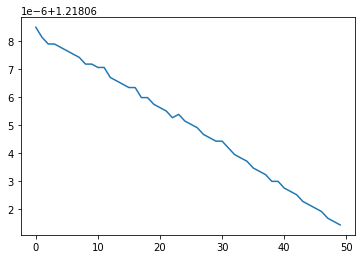

In [58]:
# plot the loss
fig, ax = plt.subplots()

ax.plot(np.arange(epochs), torch.sum(losses, axis = 0)/batch_size)

plt.show()

Since everything is in low dimension, we can interpret what our model has learned. We plot the three learned features below, and see that they do not separate the paths into the three classes as well as the $1$-form model.

/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_93310/627557330.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(torch.nn.functional.softmax(X))


Accuracy of the network on the 300 training paths: ", 33 %


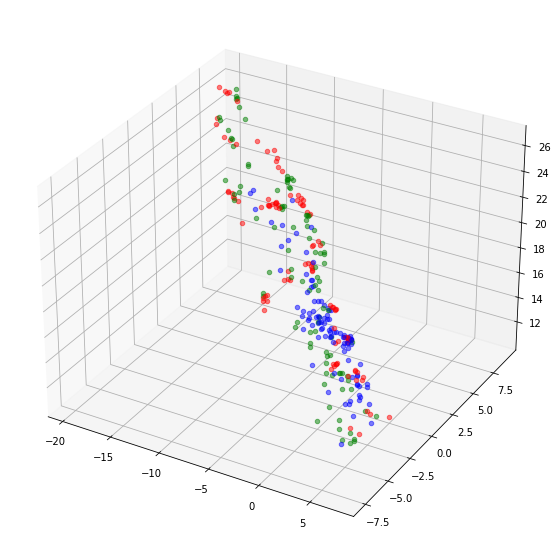

In [59]:
# make a 3d scatter plot of vf evaluated on the set of paths, colored by labels
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

# evaluate the accuracy of the classifier on the training data
correct = 0
total = 0

for i in range(len(paths)):
        
        p = paths[i]
        l = labels[i]
        
        out = scalar(torch.tensor(p).float())
        X = torch.sum(out, dim = 0)

        lb = torch.argmax(l)

        pred = torch.argmax(torch.nn.functional.softmax(X))

        if pred == torch.argmax(l):
                correct += 1
        total += 1
        
        
        if lb == 0:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), X[2].detach().numpy(), color = 'green', alpha = 0.5)
        elif lb == 1:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), X[2].detach().numpy(), color = 'red', alpha = 0.5)
        elif lb == 2:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), X[2].detach().numpy(), color = 'blue', alpha = 0.5)


# add a title to the figure
# ax.set_title('Final feature scalar field embedding')

# print accuracy
print('Accuracy of the network on the 300 training paths: ", %d %%' % (100 * correct / total))

# save the figure
fig.savefig('./figures/synthetic-paths/final-scalar-field-embedding.png')


Finally, below we plot the paths against the features. Learning a set of $0$-forms is akin to learning a set of densities that distinguish the points on along the path in the three classes. Since our paths have a lot of overlap, this is a difficult task. One can see the learned densities do roughly correspond to unique regions of the paths, but this is insufficient to distinguish paths reliably.

In conclusions, the model does not perform as well as the $1$-form model with the same number of parameters and all else equal. Indeed, this shows that in this example the $1$-simplices seem to be helpful in classifying the paths. 

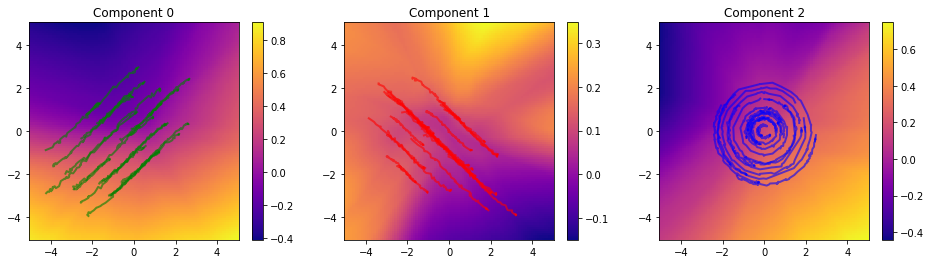

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

# plot the three component vector fields
for i in range(3):
    ax = axs[i]
    plot_scalar_field_comp(scalar, ax, comp = i, x_range=5, y_range=5)

# add a title to the figure
# fig.suptitle('Final feature scalar fields')

# add example paths from each class
for i in range(20):

    plot_path(paths[0+i], axs[0], color = 'green', alpha = 0.6, linewidth = 2)

    plot_path(paths[100+i], axs[1], color = 'red', alpha = 0.6, linewidth = 2)

    plot_path(paths[200+i], axs[2], color = 'blue', alpha = 0.6, linewidth = 2)

# save  the figure
fig.savefig('./figures/synthetic-paths/final-scalar-fields.png')

plt.show()
